In [1]:
%matplotlib inline

In [2]:
import sys

In [3]:
import matplotlib.pyplot as plt

In [4]:
import os

In [5]:
import matplotlib as mpl

In [6]:
sys.executable

'/home/nils/anaconda3/envs/datafusion/bin/python'

In [7]:
sys.path

['/home/nils/data_fusion',
 '/home/nils/anaconda3/envs/datafusion/lib/python37.zip',
 '/home/nils/anaconda3/envs/datafusion/lib/python3.7',
 '/home/nils/anaconda3/envs/datafusion/lib/python3.7/lib-dynload',
 '',
 '/home/nils/anaconda3/envs/datafusion/lib/python3.7/site-packages',
 '/home/nils/anaconda3/envs/datafusion/lib/python3.7/site-packages/IPython/extensions',
 '/home/nils/.ipython']

In [8]:
sys.path.append("/home/nils/data_fusion/nuscenes-devkit/python-sdk")

In [9]:
from nuscenes.nuscenes import NuScenes

In [10]:
nusc = NuScenes(version='v1.0-mini', dataroot='nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.6 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [11]:
from nuscenes.utils.data_classes import LidarPointCloud

In [12]:
from nuscenes.utils.geometry_utils import view_points
import numpy as np

In [13]:
from PIL import Image

In [14]:
from pyquaternion import Quaternion

# 1c

# Scene
20 second snippet of a car's journey.
A scene is a 20s long sequence of consecutive frames extracted from a log. Multiple scenes can come from the same log. Note that object identities (instance tokens) are not preserved across scenes.


# Instance
Enumeration of all object instance we observed.
An object instance, e.g. particular vehicle. This table is an enumeration of all object instances we observed. Note that instances are not tracked across scenes.

# Sample
An annotated snapshot of a scene at a particular timestamp.
A sample is data collected at (approximately) the same timestamp as part of a single LIDAR sweep.
We define sample as an annotated keyframe of a scene at a given timestamp. 

A keyframe is a frame where the time-stamps of data from all the sensors should be very close to the time-stamp of the sample it points to.

# Sample Annotation
An annotated instance of an object within our interest.
A bounding box defining the position of an object seen in a sample. All location data is given with respect to the global coordinate system.

## Picking a random sample

In [16]:
my_sample = nusc.sample[10]

In [17]:
my_scene_token =my_sample['scene_token']

In [18]:
my_scene = nusc.get('scene', my_scene_token)

In [19]:
# pick first frame of scene
first_sample_token = my_scene['first_sample_token']

In [20]:
first_sample_from_scene = nusc.get('sample', first_sample_token)

# 1d

## Picking the van in front by hand

In [21]:
vehicle_annotation_tokens = []
for i in range(len(first_sample_from_scene['anns'])):
    first_annotation_token_of_first_sample = first_sample_from_scene['anns'][i]
    if nusc.get('sample_annotation', first_annotation_token_of_first_sample)['category_name'] == 'vehicle.car':
        vehicle_annotation_tokens.append(first_annotation_token_of_first_sample)

In [22]:
# annotation of first frame
van_annotation_token = vehicle_annotation_tokens[7]

## Instance can be plotteded directly

In [23]:
my_instance_token = nusc.get('sample_annotation', van_annotation_token)['instance_token']

In [24]:
nusc.get('instance', my_instance_token)

{'token': 'c1958768d48640948f6053d04cffd35b',
 'category_token': 'fd69059b62a3469fbaef25340c0eab7f',
 'nbr_annotations': 39,
 'first_annotation_token': '49f76277d07541c5a584aa14c9d28754',
 'last_annotation_token': 'bc3180b07f8e4a728f504ded654df56f'}

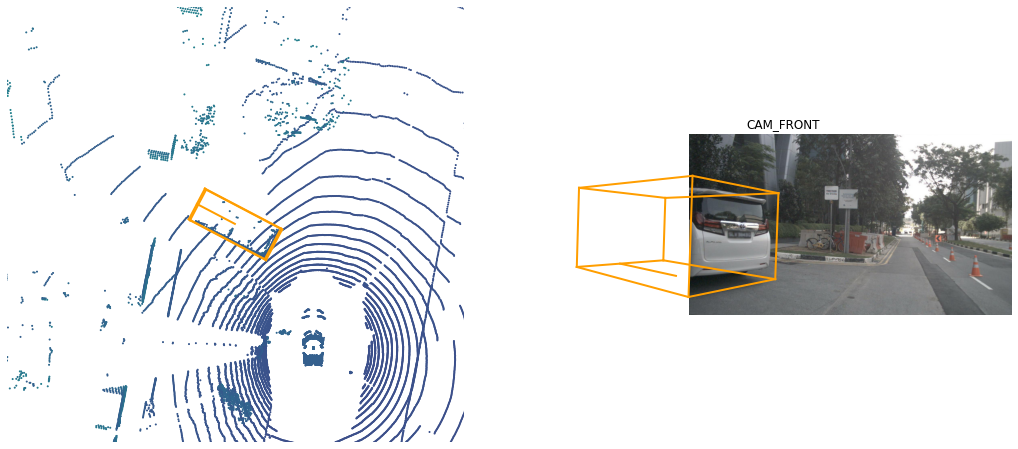

In [25]:
nusc.render_instance(my_instance_token)

# 2a

## Plot the van in the first frame

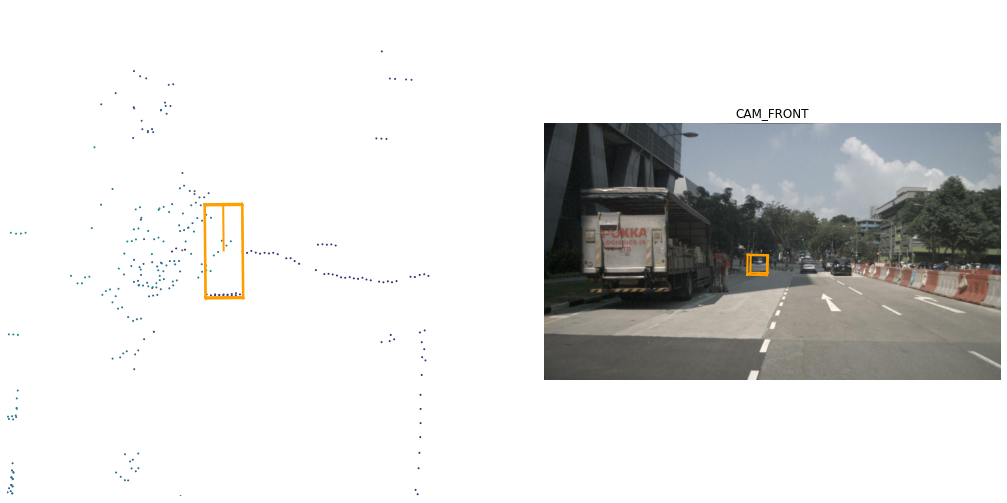

In [26]:
nusc.render_annotation(van_annotation_token)

## Plot the van in the next frame

In [27]:
next_annotation_token = nusc.get('sample_annotation', van_annotation_token)['next']

In [28]:
#nusc.render_annotation(next_annotation_token)

In [29]:
next_annotation_token = nusc.get('sample_annotation', next_annotation_token)['next']

#nusc.render_annotation(next_annotation_token)

## Last frame

In [30]:
annotation_token_of_last_sample = nusc.get('instance', my_instance_token)['last_annotation_token']

In [31]:
#nusc.render_annotation(annotation_token_of_last_sample)

## 2b + 2c

In [52]:
def visualize_sample_frontcamera(sample_token):
    # visualizing the frame with front camera
    sample_record = nusc.get('sample', sample_token)
    camera_channel = 'CAM_FRONT'
    camera_token = sample_record['data'][camera_channel]
    cam = nusc.get('sample_data', camera_token)
    im = Image.open(os.path.join(nusc.dataroot, cam['filename']))
    return im

In [53]:
def get_lidar_pointcloud(sample_token):
    sample_record = nusc.get('sample', sample_token)
    pointsensor_channel = 'LIDAR_TOP'
    pointsensor_token = sample_record['data'][pointsensor_channel]
    pointsensor = nusc.get('sample_data', pointsensor_token)
    pcl_path = nusc.get('sample_data', pointsensor_token)['filename']
    pc =LidarPointCloud.from_file(os.path.join('nuscenes',pcl_path))
    return pointsensor_token, pc.points

In [54]:
def rotate_pointcloud(cloud, quaternion):
    def rot(an_array):
        return quaternion.rotate(an_array)
    return np.array(list(map(rot, cloud)))

In [55]:
def visualize_absolute(ax, absolute_points, ego_pose, van_translation, relativeboxvectors):
    #plt.axis('equal')
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    #axes.set_ylim([ymin,ymax])
    #ax.set(xlim=(300, 500), ylim=(1100, 1300))
    return ax.scatter(absolute_points[0], absolute_points[1], c='red', s=0.3), ax.scatter(ego_pose['translation'][0], ego_pose['translation'][1]),ax.plot([van_translation[0] + relativeboxvector[0] for relativeboxvector in relativeboxvectors], [van_translation[1] + relativeboxvector[1] for relativeboxvector in relativeboxvectors])[0]
    
    

In [56]:
#create list of annotation tokens
current_van_annotation_token = van_annotation_token
annotation_tokens = []
while current_van_annotation_token != '':
    annotation_tokens.append(current_van_annotation_token)
    #next annotaton token
    current_van_annotation_token = nusc.get('sample_annotation', current_van_annotation_token)['next']

In [57]:
def create_bounding_box(annotation_token):
    '''
    creates bounding box used for plotting
    '''
    van_annotation = nusc.get('sample_annotation', annotation_token)
    relativeboxvectors = [(van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0),
                         (-van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0),
                         (-van_annotation['size'][1]/2,-van_annotation['size'][0]/2, 0),
                         (van_annotation['size'][1]/2,-van_annotation['size'][0]/2, 0),
                         (van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0)]
    return np.array(relativeboxvectors)

(280.8706444085427, 525.3293464268693, 994.264818027316, 1295.274735631)

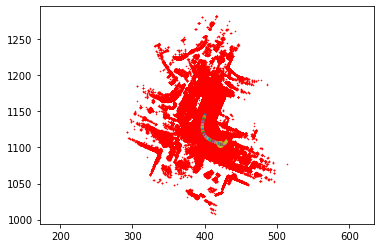

In [58]:
ims = []
fig = plt.figure()
ax = fig.add_subplot(111)  # fig and axes created once
frontimages = []

# Display points and bounding box in global coordinates over whole scene
for i,current_van_annotation_token in enumerate(annotation_tokens):
    
    # Grab the data
    
    van_annotation = nusc.get('sample_annotation', current_van_annotation_token)
    #van_annotation['rotation']#w, x, y, z
    #van_annotation['translation']# center_x, center_y, center_z

    #get respective frame token
    sample_token = van_annotation['sample_token']

    frontimage = visualize_sample_frontcamera(sample_token)
    frontimages.append(frontimage)
    
    pointsensor_token, points = get_lidar_pointcloud(sample_token)
    calibrated_sensor_token = nusc.get('sample_data', pointsensor_token)['calibrated_sensor_token']
    calibrated_sensor = nusc.get('calibrated_sensor', calibrated_sensor_token)
    ego_pose = nusc.get('ego_pose', nusc.get('sample_data', pointsensor_token)['ego_pose_token'])

    
    # Rotate points around sensor and ego rotation
    
    pointsensor_quaternion = Quaternion(calibrated_sensor['rotation'])
    reverse_van_quaternion = Quaternion(w=-1*van_annotation['rotation'][0], x=van_annotation['rotation'][1], y=van_annotation['rotation'][2], z=van_annotation['rotation'][3])
    ego_quaternion = Quaternion(ego_pose['rotation'])
    
    #using rotate_pointcloud function is slow:
    #rotated_points = np.swapaxes(rotate_pointcloud(np.swapaxes(points[:3,:],0,1), ego_quaternion),0,1)

    #using numpy is faster:
    sensor_rotated_points = np.dot(pointsensor_quaternion.rotation_matrix, points[:3,:])
    rotated_points = np.dot(ego_quaternion.rotation_matrix, sensor_rotated_points)

    # use broadcasting to add translation to x and y dimension
    absolute_points = rotated_points+np.array(ego_pose['translation'][:3]).reshape(-1,1)



    ### rotated bounding box
    van_quaternion = Quaternion(van_annotation['rotation'])
    #van_annotation['size']#bounding box size: width, length, height
    relativeboxvectors = create_bounding_box(current_van_annotation_token)
    relativeboxvectors = rotate_pointcloud(relativeboxvectors, van_quaternion)
    
    # append list of plots to movie
    plotlist = visualize_absolute(ax, absolute_points, ego_pose, van_annotation['translation'], relativeboxvectors)
    ims.append(plotlist)      
# Because Hauke loves it :D
ax.axis('equal')

In [49]:
ims[0]

(<matplotlib.collections.PathCollection at 0x7f0d84de1650>,
 <matplotlib.lines.Line2D at 0x7f0d850423d0>)

In [50]:
ani = mpl.animation.ArtistAnimation(fig, ims, repeat=False)
ani.save('im.gif', writer='pillow')

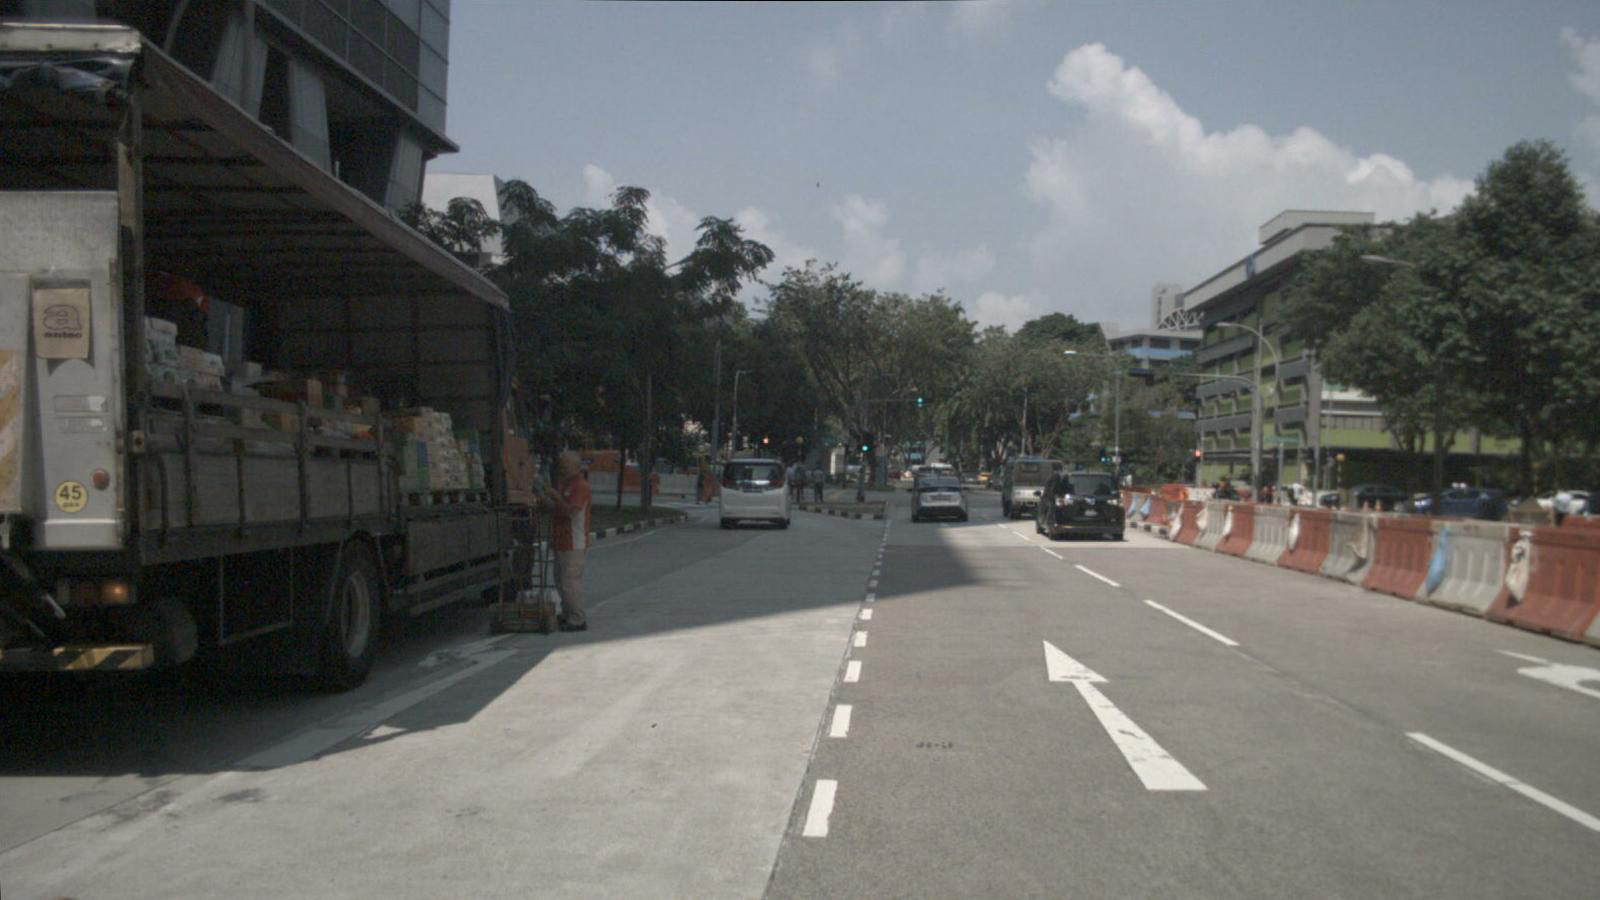

In [62]:
frontimages[0]

In [63]:
# doesnt work like that
#ani_front = mpl.animation.ArtistAnimation(fig, frontimages, repeat=False)
#ani_front.save('im_front.gif', writer='pillow')

# End of tasks

In [ ]:
## filtering out points outside bounding box

### translating points to car reference frame

#ego_quaternion = Quaternion(w=1*ego_pose['rotation'][0], x=ego_pose['rotation'][1], y=ego_pose['rotation'][2], z=ego_pose['rotation'][3])
#ego_quaternion.rotate(np.array((0,1,0)))

# use broadcasting to add translation to x and y dimension
points_in_van_reference = absolute_points-np.array(van_annotation['translation']).reshape(-1,1)


In [ ]:
## displaying points in van reference
plt.scatter(points_in_van_reference[0], points_in_van_reference[1], c='red', s=0.5)
plt.plot((0,ego_pose['translation'][0]-van_annotation['translation'][0]),(0,ego_pose['translation'][1]-van_annotation['translation'][1]))
plt.plot([relativeboxvector[0] for relativeboxvector in relativeboxvectors]
          , [relativeboxvector[1] for relativeboxvector in relativeboxvectors])
plt.axis('equal')

In [ ]:
points_in_van_reference_rotated = rotate_pointcloud(points_in_van_reference, reverse_van_quaternion)

In [ ]:

rotated_reference_vector =reverse_van_quaternion.rotate((ego_x_translation[0]-van_x_translation[0],ego_y_translation[9]-van_y_translation[0],0))

## displaying points in van reference including orientation
plt.scatter(points_in_van_reference_rotated[0], points_in_van_reference_rotated[1], c='red', s=0.5)
plt.plot((0,rotated_reference_vector[0]),(0,rotated_reference_vector[1]))
plt.plot([relativeboxvector[0] for relativeboxvector in relativeboxvectors]
          , [relativeboxvector[1] for relativeboxvector in relativeboxvectors])
plt.axis('equal')

In [ ]:
## Remove points that are outside the bounding box
depths = pc.points[2, :]
depths.shape

In [ ]:
mask = np.ones(depths.shape[0], dtype=bool)
#rotated[0], rotated[1]


mask = np.logical_and(mask, rotated[0] > -(van_annotation['size'][0])/2)
mask = np.logical_and(mask, rotated[0] < (van_annotation['size'][0])/2)

In [ ]:
mask = np.logical_and(mask, rotated[1] > -(van_annotation['size'][1])/2)
mask = np.logical_and(mask, rotated[1] < (van_annotation['size'][1])/2)

In [ ]:
#mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
#mask = np.logical_and(mask, points[1, :] > 1)
#mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)

#points = points[:, mask]
#absolute_points_x = absolute_points_x[:, mask]
#coloring = depths
#coloring = coloring[mask]

In [ ]:
masked_rotated_x = rotated[0][mask]

In [ ]:
masked_rotated_y = rotated[1][mask]

In [ ]:
## displaying points in van reference
plt.scatter(masked_rotated_x, masked_rotated_y, c='red', s=0.5)
plt.plot((0,rotated_reference_vector[0]),(0,rotated_reference_vector[1]))
plt.plot([relativeboxvector[0] for relativeboxvector in relativeboxvectors]
          , [relativeboxvector[1] for relativeboxvector in relativeboxvectors])
plt.axis('equal')

## builtin render sample data

In [ ]:
lidar_data = nusc.get('sample_data', my_sample['data']['LIDAR_TOP'])
cam_front_data = nusc.get('sample_data', my_sample['data']['CAM_FRONT'])

In [ ]:
nusc.render_sample_data(cam_front_data['token'])

In [ ]:
nusc.render_sample_data(lidar_data['token'])

In [ ]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

In [ ]:
nusc.render_sample_data(my_sample['data']['CAM_FRONT'])